## **Visualisation des parcelles dédiées à l'agriculture biologique en France** 

In [1]:
!pip install geopandas fiona pyogrio shapely

In [2]:
import geopandas as gpd
file_path = "/home/onyxia/work/rpg-bio-2023-national.gpkg"
# Charger le fichier GPKG avec geopandas
gdf = gpd.read_file(file_path)
# Afficher les 5 premières lignes pour vérifier les données
print("Aperçu des données :")
print(gdf.head())

Aperçu des données :
       gid  millesime code_culture precision_culture  \
0  3522951       2023          CPL               001   
1  3522960       2023          LUZ               002   
2  3522963       2023          ORP               001   
3  3522969       2023          TTH               001   
4  3703073       2023          BOR              None   

                                         lbl_culture      grp_culture  \
0  Mélange multi-espèces (céréales, oléagineux, l...         Fourrage   
1                                      Autre luzerne         Fourrage   
2                                  Orge de printemps             Orge   
3                                  Triticale d’hiver  Autres céréales   
4                                   Bordure de champ           Divers   

   surface_ha code_commune_insee               lbl_commune    code_epci  \
0        5.36              32080  Castelnau-sur-l'Auvignon  243200417.0   
1        4.97              32054                     

In [3]:
gdf.columns

Index(['gid', 'millesime', 'code_culture', 'precision_culture', 'lbl_culture',
       'grp_culture', 'surface_ha', 'code_commune_insee', 'lbl_commune',
       'code_epci', 'code_departement', 'code_region', 'zone_geo', 'geometry'],
      dtype='object')

Travail sur la base de données pour rendre réduire la complexité du travail pour le code 

In [4]:
import pandas as pd

# Obtenir des statistiques descriptives
surface_stats = gdf["surface_ha"].describe()

# Afficher les statistiques
print("Statistiques descriptives de la surface des parcelles (en hectares) :")
print(surface_stats)


Statistiques descriptives de la surface des parcelles (en hectares) :
count    1.165465e+06
mean     2.458880e+00
std      1.186557e+01
min      0.000000e+00
25%      3.700000e-01
50%      1.040000e+00
75%      2.630000e+00
max      6.529650e+03
Name: surface_ha, dtype: float64


In [ ]:
import folium

def create_map_for_region(region_code, gdf, output_dir="maps"):
    """
    Génère une carte pour une région spécifique.
    
    Args:
        region_code (str): Le code de la région à filtrer.
        gdf (GeoDataFrame): Le GeoDataFrame contenant toutes les données.
        output_dir (str): Répertoire où enregistrer la carte.
    """
    # Filtrer les données pour la région
    gdf_region = gdf[gdf["code_region"] == region_code]
    
    # Simplifier les géométries pour alléger la carte
    gdf_region["geometry"] = gdf_region["geometry"].simplify(tolerance=0.01)

    # Créer une carte centrée sur la région
    m = folium.Map(location=[46.603354, 1.888334], zoom_start=6)

    # Ajouter les données géospatiales
    folium.GeoJson(
        gdf_region,
        name=f"Région {region_code}",
        tooltip=folium.GeoJsonTooltip(fields=["lbl_culture", "surface_ha", "lbl_commune"],
                                      aliases=["Culture", "Surface (ha)", "Commune"])
    ).add_to(m)

    # Créer un nom de fichier basé sur la région
    map_file = f"{output_dir}/map_region_{region_code}.html"

    # Enregistrer la carte
    m.save(map_file)
    print(f"Carte enregistrée pour la région {region_code} : {map_file}")


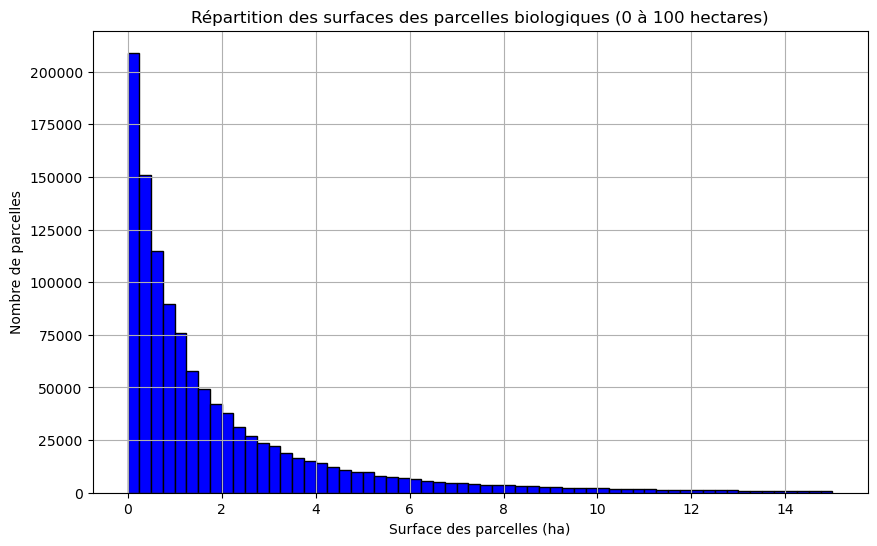

In [13]:
import matplotlib.pyplot as plt

# Créer un histogramme limité entre 0 et 100 hectares
plt.figure(figsize=(10, 6))
plt.hist(gdf["surface_ha"], bins=60, range=(0, 15), color="blue", edgecolor="black")
plt.title("Répartition des surfaces des parcelles biologiques (0 à 100 hectares)")
plt.xlabel("Surface des parcelles (ha)")
plt.ylabel("Nombre de parcelles")
plt.grid(True)
plt.show()

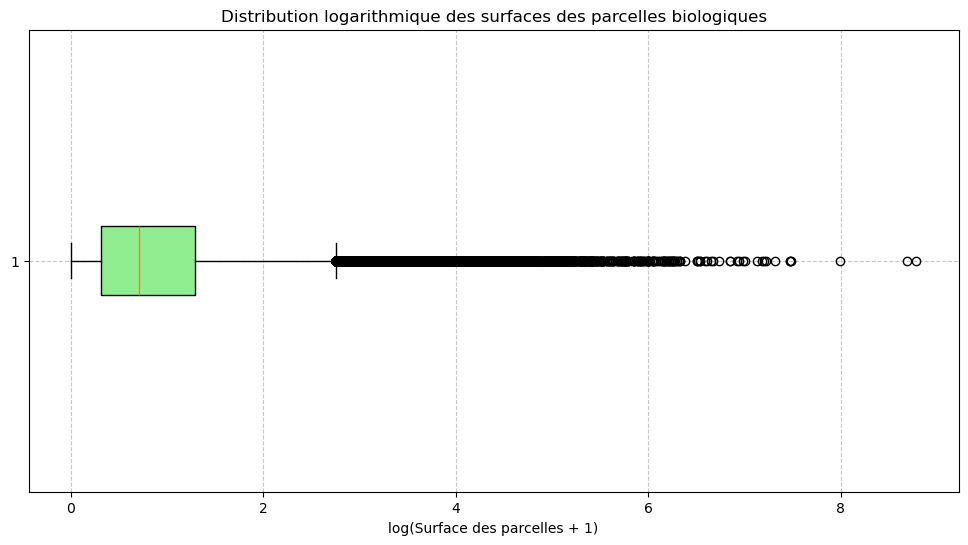

In [17]:
import numpy as np

# Ajouter une colonne avec la transformation logarithmique
gdf["log_surface_ha"] = np.log1p(gdf["surface_ha"])  # log(1 + surface_ha) pour éviter log(0)

# Créer un boxplot de la surface transformée
plt.figure(figsize=(12, 6))
plt.boxplot(gdf["log_surface_ha"], vert=False, patch_artist=True, boxprops=dict(facecolor="lightgreen", color="black"))
plt.title("Distribution logarithmique des surfaces des parcelles biologiques")
plt.xlabel("log(Surface des parcelles + 1)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()




In [28]:
# Dictionnaire des codes des régions et de leurs noms
region_names = {
    "84": "Auvergne-Rhône-Alpes",
    "27": "Bourgogne-Franche-Comté",
    "53": "Bretagne",
    "24": "Centre-Val de Loire",
    "94": "Corse",
    "44": "Grand Est",
    "32": "Hauts-de-France",
    "11": "Île-de-France",
    "28": "Normandie",
    "75": "Nouvelle-Aquitaine",
    "76": "Occitanie",
    "52": "Pays de la Loire",
    "93": "Provence-Alpes-Côte d'Azur",
    "01": "Guadeloupe",
    "02": "Martinique",
    "03": "Guyane",
    "04": "La Réunion",
    "06": "Mayotte"
}


In [30]:
# Ajouter ou mettre à jour la colonne "nom_region" avec les noms mappés
gdf["nom_region"] = gdf["code_region"].map(region_names)

# Vérifier que les noms sont bien associés
print(gdf[gdf["code_region"] == "76"][["code_region", "nom_region"]].head())



Empty DataFrame
Columns: [code_region, nom_region]
Index: []


In [31]:
# Remplacer les valeurs NaN par "Région inconnue"
gdf["nom_region"] = gdf["nom_region"].fillna("Région inconnue")

# Vérifier le résultat pour le code 76
print(gdf[gdf["code_region"] == "76"][["code_region", "nom_region"]].head())


Empty DataFrame
Columns: [code_region, nom_region]
Index: []


Codes région non mappés : []


In [20]:
# Calcul des statistiques descriptives
Q1 = gdf["surface_ha"].quantile(0.25)  # Premier quartile
Q3 = gdf["surface_ha"].quantile(0.75)  # Troisième quartile
IQR = Q3 - Q1  # Etendue interquartile

# Définir une surface minimale basée sur le premier quartile
surface_min = Q1
surface_max = Q3 + 1.5 * IQR  # Facultatif, pour filtrer les outliers
print(f"Surface minimale : {surface_min:.2f} ha")
print(f"Surface maximale (sans outliers) : {surface_max:.2f} ha")

# Filtrer les parcelles avec une surface > 1 hectare
gdf_filtered = gdf[gdf["surface_ha"] > 1]

# Nombre de parcelles restantes
print(f"Nombre de parcelles après filtrage : {len(gdf_filtered)}")


Surface minimale : 0.37 ha
Surface maximale (sans outliers) : 6.02 ha
Nombre de parcelles après filtrage : 595771


In [21]:
import folium
import os

def create_map_for_region(region_code, gdf, surface_min=1, output_dir="maps"):
    """
    Génère une carte pour une région spécifique en filtrant sur une surface minimale.
    
    Args:
        region_code (str): Code de la région à filtrer.
        gdf (GeoDataFrame): GeoDataFrame contenant les données de toutes les parcelles.
        surface_min (float): Surface minimale en hectares pour inclure une parcelle.
        output_dir (str): Répertoire où enregistrer la carte générée.
    """
    # Créer le répertoire de sortie s'il n'existe pas
    os.makedirs(output_dir, exist_ok=True)
    
    # Filtrer les parcelles par région et surface minimale
    gdf_region = gdf[(gdf["code_region"] == region_code) & (gdf["surface_ha"] > surface_min)]
    
    # Vérifier si des parcelles répondent au critère
    if gdf_region.empty:
        print(f"Aucune parcelle à afficher pour la région {region_code} avec surface > {surface_min} ha.")
        return
    
    # Simplifier les géométries pour alléger la carte
    gdf_region["geometry"] = gdf_region["geometry"].simplify(tolerance=0.01)
    
    # Créer une carte centrée sur la France métropolitaine
    m = folium.Map(location=[46.603354, 1.888334], zoom_start=6)

    # Ajouter les données géospatiales
    folium.GeoJson(
        gdf_region,
        name=f"Région {region_code}",
        tooltip=folium.GeoJsonTooltip(fields=["lbl_culture", "surface_ha", "lbl_commune"],
                                      aliases=["Culture", "Surface (ha)", "Commune"])
    ).add_to(m)

    # Créer un nom de fichier pour la région
    map_file = os.path.join(output_dir, f"map_region_{region_code}.html")
    
    # Enregistrer la carte
    m.save(map_file)
    print(f"Carte générée pour la région {region_code} avec surface > {surface_min} ha : {map_file}")


In [23]:
# Filtrer uniquement les parcelles en France métropolitaine
gdf = gdf[gdf["zone_geo"] == "France mét."]

# Liste des régions uniques
regions = gdf["code_region"].unique()

# Générer une carte pour chaque région
for region_code in regions:
    create_map_for_region(region_code, gdf, surface_min=1, output_dir="maps")


/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Carte générée pour la région 76 avec surface > 1 ha : maps/map_region_76.html


/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Carte générée pour la région 75 avec surface > 1 ha : maps/map_region_75.html


/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Carte générée pour la région 53 avec surface > 1 ha : maps/map_region_53.html


/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Carte générée pour la région 24 avec surface > 1 ha : maps/map_region_24.html


/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Carte générée pour la région 84 avec surface > 1 ha : maps/map_region_84.html


/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Carte générée pour la région 27 avec surface > 1 ha : maps/map_region_27.html


/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Carte générée pour la région 28 avec surface > 1 ha : maps/map_region_28.html


/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Carte générée pour la région 52 avec surface > 1 ha : maps/map_region_52.html


/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Carte générée pour la région 93 avec surface > 1 ha : maps/map_region_93.html


/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Carte générée pour la région 11 avec surface > 1 ha : maps/map_region_11.html


/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Carte générée pour la région 44 avec surface > 1 ha : maps/map_region_44.html


/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Carte générée pour la région 32 avec surface > 1 ha : maps/map_region_32.html


/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Carte générée pour la région 94 avec surface > 1 ha : maps/map_region_94.html
Carte générée pour la région 978 avec surface > 1 ha : maps/map_region_978.html


/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [25]:
from IPython.display import IFrame, display
def show_map(file_path, width="100%", height="500"):
    """
    Affiche une carte HTML dans un notebook.

    Args:
        file_path (str): Chemin du fichier HTML de la carte.
        width (str): Largeur de l'affichage (par défaut : 100%).
        height (str): Hauteur de l'affichage (par défaut : 500px).
    """
    display(IFrame(file_path, width=width, height=height))


In [27]:
# Liste des fichiers HTML (par exemple, générée précédemment)
map_files = [
    "maps/map_region_84.html",
    "maps/map_region_27.html",
    "maps/map_region_53.html",
    "maps/map_region_24.html",
    "maps/map_region_94.html",
    "maps/map_region_44.html",
    "maps/map_region_32.html",
    "maps/map_region_11.html",
    "maps/map_region_28.html",
    "maps/map_region_75.html",
    "maps/map_region_76.html",
    "maps/map_region_52.html",
    "maps/map_region_93.html",
    "maps/map_region_01.html",
]

# Afficher toutes les cartes
show_map(map_file, width="80%", height="600")

